Average regret for truthful bidders: {0: array([ 1.00000000e-01,  2.00000000e-01,  4.96969697e-01,  6.96969697e-01,
        6.96969697e-01,  6.96969697e-01,  6.96969697e-01,  6.96969697e-01,
        6.96969697e-01,  6.96969697e-01,  6.96969697e-01,  6.96969697e-01,
        6.96969697e-01,  6.96969697e-01,  6.96969697e-01,  6.96969697e-01,
        6.96969697e-01,  6.96969697e-01,  6.96969697e-01,  6.96969697e-01,
        6.96969697e-01,  6.96969697e-01,  6.96969697e-01,  8.96969697e-01,
        8.96969697e-01,  8.96969697e-01,  8.96969697e-01,  1.09696970e+00,
        1.09696970e+00,  1.09696970e+00,  1.09696970e+00,  1.34819394e+00,
        1.56924657e+00,  1.66924657e+00,  1.76924657e+00,  1.89556236e+00,
        1.99029920e+00,  1.99029920e+00,  1.99029920e+00,  1.99029920e+00,
        1.99029920e+00,  1.99029920e+00,  1.99029920e+00,  1.99029920e+00,
        1.99029920e+00,  1.99029920e+00,  2.09029920e+00,  2.09029920e+00,
        2.09029920e+00,  2.19029920e+00,  2.19029920e+00,  

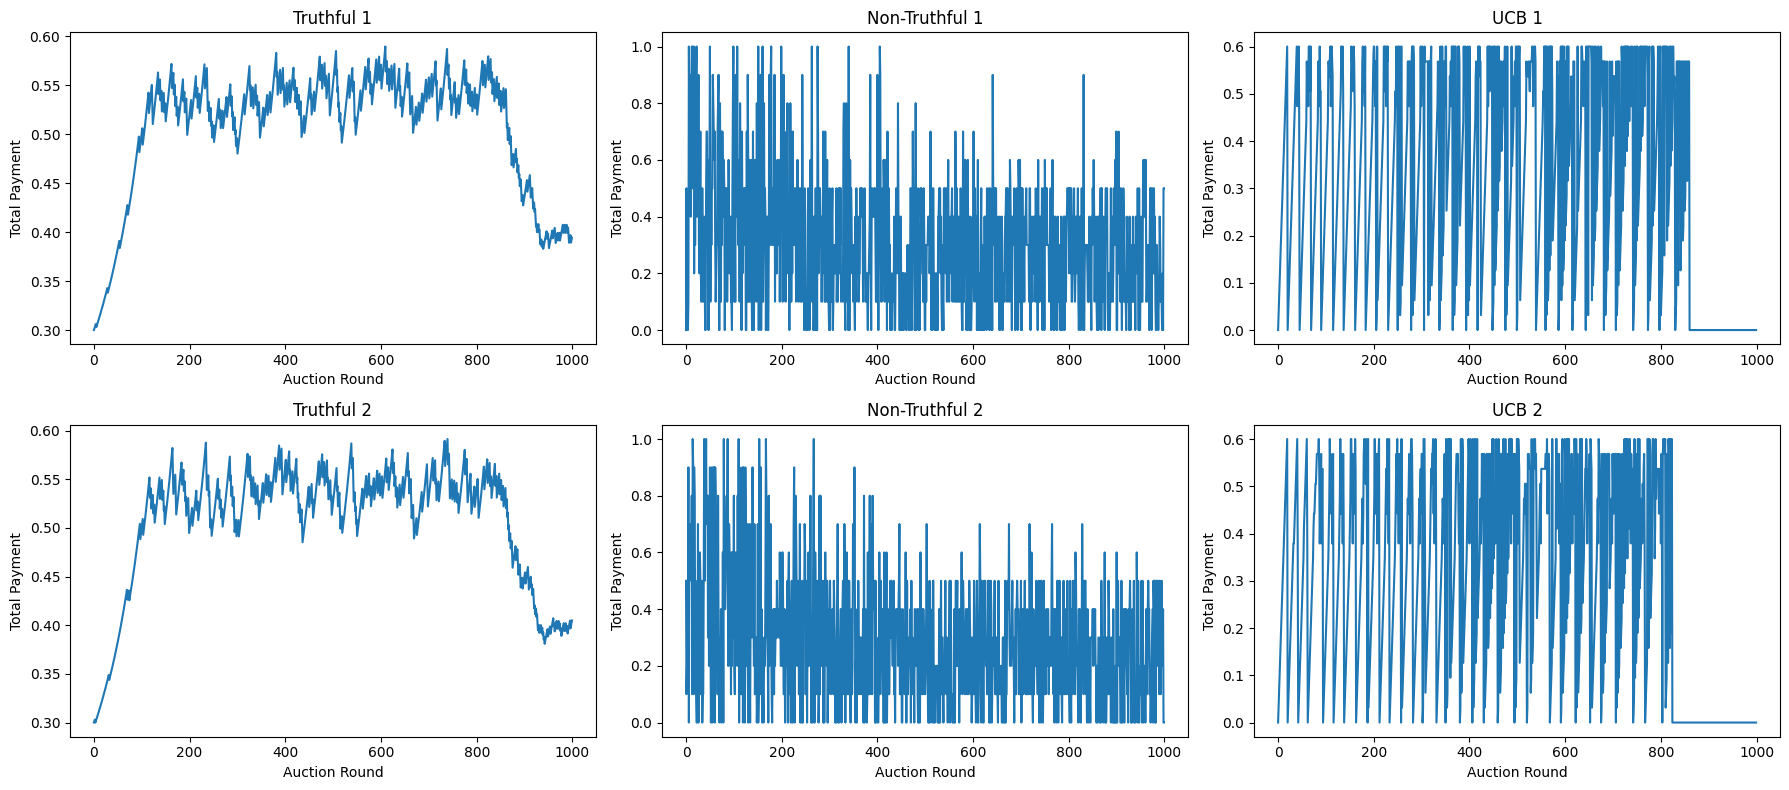

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from bidding_agents import MultiplicativePacingAgent as PrimalDualTruthful
from bidding_agents import FFMultiplicativePacingAgent as PrimalDualNonTruthful
from bidding_agents import ucblike as UCB

class FirstPriceAuction:
    def __init__(self, num_bidders):
        self.ctrs = np.ones(num_bidders) 
        self.n_adv = len(self.ctrs)

    def round(self, bids):
        winners, values = self.get_winners(bids) # Allocation mechanism
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = values[winners]/self.ctrs[winners]
        return payment.round(2)

def get_clairvoyant_truthful(B, my_valuation, m_t, t):
    utility = (my_valuation - m_t) * (my_valuation >= m_t)
    
    sorted_round_utility = np.flip(np.argsort(utility))
    
    clairvoyant_utilities = np.zeros(t)
    clairvoyant_bids = np.zeros(t)
    clairvoyant_payments = np.zeros(t)
    
    c = 0
    i = 0
    while c <= B - 1 and i < t:
        index = sorted_round_utility[i]
        clairvoyant_bids[index] = 1
        clairvoyant_utilities[index] = utility[index]
        clairvoyant_payments[index] = m_t[index]
        c += m_t[index]
        i += 1
    
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

def simulate_auction(num_bidders, budget, T, eta, valuation, bids_set, epochs=10):
    
    all_results = {i: [] for i in range(num_bidders)}
    all_regret = {i: [] for i in range(num_bidders)}
    avg_regret_t = {i: [] for i in range(num_bidders)}
    std_regret_t = {i: [] for i in range(num_bidders)}
    avg_regret_nt = {i: [] for i in range(num_bidders)}
    std_regret_nt = {i: [] for i in range(num_bidders)}
    
    for epoch in range(epochs):
        # Initialize the auction environment
        auction = FirstPriceAuction(num_bidders)

        class_instances = {
            'truthful_bidder': [],
            'non_truthful_bidder': [],
            'ucb_bidder': []
        }
    
        for i in range(num_bidders):
            if i % 3 == 0:
                class_instances['truthful_bidder'].append(PrimalDualTruthful(valuation, budget, T, eta))
            elif i % 3 == 1:
                class_instances['non_truthful_bidder'].append(PrimalDualNonTruthful(bids_set, valuation, budget, T, eta))
            else:
                class_instances['ucb_bidder'].append(UCB(budget, T, 1, valuation, discretization=20, range=0.1))

        results = {
            'truthful': {i: [] for i in range(len(class_instances['truthful_bidder']))},
            'non_truthful': {i: [] for i in range(len(class_instances['non_truthful_bidder']))},
            'ucb': {i: [] for i in range(len(class_instances['ucb_bidder']))}
        }

        regret_t = {i: [] for i in range(len(class_instances['truthful_bidder']))}
        utilities_t = {i: [] for i in range(len(class_instances['truthful_bidder']))}
        m_t_t = {i: np.zeros(0) for i in range(len(class_instances['truthful_bidder']))}
        utilities_nt = {i: [] for i in range(len(class_instances['non_truthful_bidder']))}
        m_t_nt = {i: np.zeros(0) for i in range(len(class_instances['non_truthful_bidder']))}
        
        # Run the auction for the specified number of rounds
        np.random.seed(epoch)
        for t in range(T):
            bids_truthful = [instance.bid() for instance in class_instances['truthful_bidder']]
            bids_non_truthful = [instance.bid() for instance in class_instances['non_truthful_bidder']]
            bids_ucb = [instance.bid() for instance in class_instances['ucb_bidder']]

            bids = np.hstack((bids_truthful, bids_non_truthful, bids_ucb))
            
            winners, payments_per_click = auction.round(bids=bids)

            if isinstance(winners, (int, np.integer)):
                winners = [winners]

            # Update algorithms with the reward
            
            for i, truthful_instance in enumerate(class_instances["truthful_bidder"]):
                other_truthful_bids = [bid for j, bid in enumerate(bids_truthful) if j != i]
                other_bids = np.hstack((other_truthful_bids, bids_non_truthful, bids_ucb))
                truthful_bid_index = i
                my_win = int(truthful_bid_index in winners)
                m_t = other_bids.max(axis=0)
                f_t, c_t = (valuation - m_t) * my_win, m_t * my_win
                truthful_instance.update(f_t, c_t)
                utilities_t[i].append(f_t)
                m_t_t[i] = np.append(m_t_t[i], m_t)

            for i, non_truthful_instance in enumerate(class_instances["non_truthful_bidder"]):
                other_non_truthful_bids = [bid for j, bid in enumerate(bids_non_truthful) if j != i]
                other_bids = np.hstack((bids_truthful, other_non_truthful_bids, bids_ucb))
                non_truthful_bid_index = len(bids_truthful) + i
                my_win = int(non_truthful_bid_index in winners)
                m_t = other_bids.max()
                f_t, c_t = (valuation - m_t) * my_win, m_t * my_win
                non_truthful_instance.update(f_t, c_t, m_t)
                utilities_nt[i].append(f_t)
                m_t_nt[i] = np.append(m_t_nt[i], m_t)

            for i, ucb_instance in enumerate(class_instances["ucb_bidder"]):
                other_ucb_bids = [bid for j, bid in enumerate(bids_ucb) if j != i]
                other_bids = np.hstack((bids_truthful, bids_non_truthful, other_ucb_bids))
                ucb_bid_index = len(bids_truthful) + len(bids_non_truthful) + i
                my_win = int(ucb_bid_index in winners)
                m_t = other_bids.max()
                f_t, c_t = (valuation - m_t) * my_win, m_t * my_win
                ucb_instance.update(f_t, c_t)


            # Record results per each instance
            for i, bid in enumerate(bids_truthful):
                results['truthful'][i].append(bid)
            for i, bid in enumerate(bids_non_truthful):
                results['non_truthful'][i].append(bid)
            for i, bid in enumerate(bids_ucb):
                results['ucb'][i].append(bid)

            all_results[epoch] = results
            all_regret[epoch] = regret_t

        # Compute the regret for truthful bidders

        clairvoyant_bids_t = {i: np.zeros(T) for i in range(len(class_instances['truthful_bidder']))}
        clairvoyant_utilities_t = {i: np.zeros(T) for i in range(len(class_instances['truthful_bidder']))}
        clairvoyant_payments_t = {i: np.zeros(T) for i in range(len(class_instances['truthful_bidder']))}
        

        for i, truthful_instance in enumerate(class_instances["truthful_bidder"]):
            clairvoyant_bids_t[i], clairvoyant_utilities_t[i], clairvoyant_payments_t[i] = get_clairvoyant_truthful(B, my_valuation, m_t_t[i], T)
            
            cumulative_regret = np.cumsum(clairvoyant_utilities_t[i] - utilities_t[i])
            regret_t[i].append(cumulative_regret)


        # Compute the regret for non-truthful bidders

        rho = B/T
        expected_clairvoyant_utilities_nt = {i: np.zeros(T) for i in range(len(class_instances['non_truthful_bidder']))}
        regret_nt = {i: [] for i in range(len(class_instances['non_truthful_bidder']))}

        for i, non_truthful_instance in enumerate(class_instances["non_truthful_bidder"]):
            win_probabilities = np.array([sum(b > m_t_nt[i])/T for b in bids_set])
            c = -(my_valuation-available_bids)*win_probabilities
            A_ub = [available_bids*win_probabilities]
            b_ub = [rho]
            A_eq = [np.ones(len(available_bids))]
            b_eq = [1]
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
            expected_clairvoyant_utilities_nt[i] = np.array([-res.fun for u in range(T)]) 
            utilities_nt[i] = np.array(utilities_nt[i])
            cumulative_regret = np.cumsum(expected_clairvoyant_utilities_nt[i] - utilities_nt[i])
            regret_nt[i].append(cumulative_regret)

    for i in range(len(class_instances['truthful_bidder'])):
        avg_regret_t[i] = np.array(regret_t[i]).mean(axis=0)
        std_regret_t[i] = np.array(regret_t[i]).std(axis=0)
    for i in range(len(class_instances['non_truthful_bidder'])):
        avg_regret_nt[i] = np.array(regret_nt[i]).mean(axis=0)
        std_regret_nt[i] = np.array(regret_nt[i]).std(axis=0)

    print(f"Average regret for truthful bidders: {avg_regret_t}")
    print(f"Average regret for non-truthful bidders: {avg_regret_nt}")
    print(f"Standard deviation of regret for truthful bidders: {std_regret_t}")
    print(f"Standard deviation of regret for non-truthful bidders: {std_regret_nt}")
    
    return results, avg_regret_t, std_regret_t, avg_regret_nt, std_regret_nt



# Set parameters and run the simulation
#TODO: Change the parameters to see how the agents behave

num_bidders = 6 # this number can be changed to whatever you want
B = 100
T = 1000
eta = 0.1
my_valuation = 0.6
available_bids = np.linspace(0,1,11)

results, avg_regret_t, std_regret_t, avg_regret_nt, std_regret_nt = simulate_auction(num_bidders, B, T, eta, my_valuation, available_bids)

# Plot the results
total_truthful = len(results['truthful'])
total_non_truthful = len(results['non_truthful'])
total_ucb = len(results['ucb'])

num_rows = max(total_truthful, total_non_truthful, total_ucb)
num_cols = 3 

fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4*num_rows))

# Plot Primal-Dual Truthful results

for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0].plot(results['truthful'][i], label=f'Truthful {i+1}')
        ax[0].set_title(f'Truthful {i+1}')
        ax[0].set_xlabel('Auction Round')
        ax[0].set_ylabel('Total Payment')
    else:
        ax[row, 0].plot(results['truthful'][i], label=f'Truthful {i+1}')
        ax[row, 0].set_title(f'Truthful {i+1}')
        ax[row, 0].set_xlabel('Auction Round')
        ax[row, 0].set_ylabel('Total Payment')


# Plot Primal-Dual Non-Truthful results

for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[1].plot(results['non_truthful'][i], label=f'Non-Truthful {i+1}')
        ax[1].set_title(f'Non-Truthful {i+1}')
        ax[1].set_xlabel('Auction Round')
        ax[1].set_ylabel('Total Payment')
    else:
        ax[row, 1].plot(results['non_truthful'][i], label=f'Non-Truthful {i+1}')
        ax[row, 1].set_title(f'Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Auction Round')
        ax[row, 1].set_ylabel('Total Payment')


# Plot UCB results

for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[2].plot(results['ucb'][i], label=f'UCB {i+1}')
        ax[2].set_title(f'UCB {i+1}')
        ax[2].set_xlabel('Auction Round')
        ax[2].set_ylabel('Total Payment')
    else:
        ax[row, 2].plot(results['ucb'][i], label=f'UCB {i+1}')
        ax[row, 2].set_title(f'UCB {i+1}')
        ax[row, 2].set_xlabel('Auction Round')
        ax[row, 2].set_ylabel('Total Payment')


for i in range(total_truthful, num_rows):
    ax[i, 0].axis('off')
for i in range(total_non_truthful, num_rows):
    ax[i, 1].axis('off')
for i in range(total_ucb, num_rows):
    ax[i, 2].axis('off')

plt.tight_layout()
plt.show()

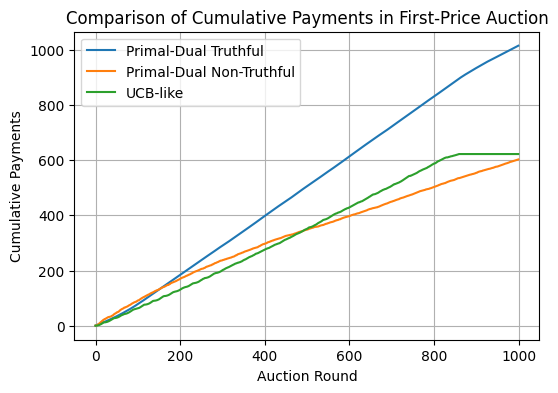

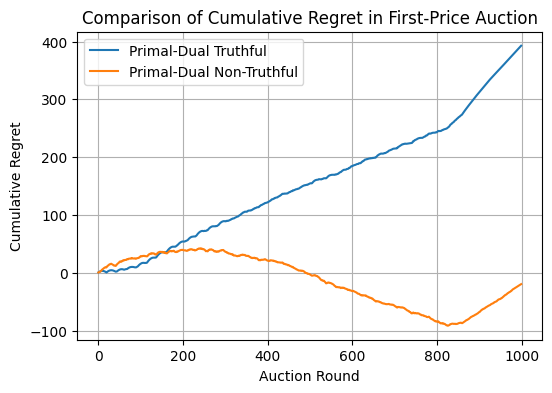

In [57]:
# Calculate cumulative payments
cumulative_payments_truthful = np.zeros(T)
cumulative_payments_non_truthful = np.zeros(T)
cumulative_payments_ucb = np.zeros(T)

for truthful_results in results['truthful'].values():
    cumulative_payments_truthful += np.cumsum(truthful_results)

for non_truthful_results in results['non_truthful'].values():
    cumulative_payments_non_truthful += np.cumsum(non_truthful_results)

for ucb_results in results['ucb'].values():
    cumulative_payments_ucb += np.cumsum(ucb_results)


# Calculate cumulative regret
#TODO: Implement the calculation of cumulative regret with clairvoyant

cumulative_regret_truthful = np.zeros(T)
cumulative_regret_non_truthful = np.zeros(T)

for truthful_results, ucb_results in zip(results['truthful'].values(), results['ucb'].values()):
    cumulative_regret_truthful += np.cumsum(truthful_results) - np.cumsum(ucb_results)

for non_truthful_results, ucb_results in zip(results['non_truthful'].values(), results['ucb'].values()):
    cumulative_regret_non_truthful += np.cumsum(non_truthful_results) - np.cumsum(ucb_results)

# Plot the cumulative payments
plt.figure(figsize=(6, 4))
plt.plot(cumulative_payments_truthful, label='Primal-Dual Truthful')
plt.plot(cumulative_payments_non_truthful, label='Primal-Dual Non-Truthful')
plt.plot(cumulative_payments_ucb, label='UCB-like')
plt.xlabel('Auction Round')
plt.ylabel('Cumulative Payments')
plt.legend()
plt.title('Comparison of Cumulative Payments in First-Price Auction')
plt.grid(True)
plt.show()

# Plot the cumulative regret
plt.figure(figsize=(6, 4))
plt.plot(cumulative_regret_truthful, label='Primal-Dual Truthful')
plt.plot(cumulative_regret_non_truthful, label='Primal-Dual Non-Truthful')
plt.xlabel('Auction Round')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.title('Comparison of Cumulative Regret in First-Price Auction')
plt.grid(True)
plt.show()

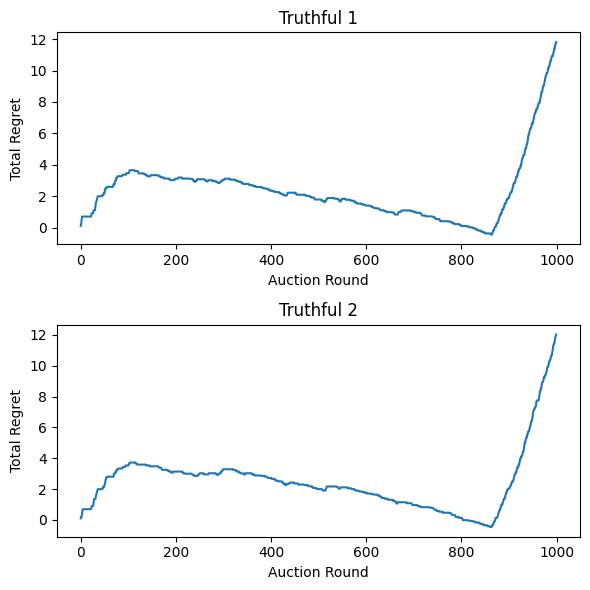

In [58]:
num_rows = total_truthful

fig1, ax1 = plt.subplots(num_rows, 1, figsize=(6, 3*num_rows))

if total_truthful == 1:
    ax1 = [ax1]

for i in range(total_truthful):
    row = i
    ax1[row].plot(np.arange(T), avg_regret_t[i])
    ax1[row].fill_between(np.arange(T), avg_regret_t[i] - std_regret_t[i], avg_regret_t[i] + std_regret_t[i], alpha=0.3)
    ax1[row].set_title(f'Truthful {i + 1}')
    ax1[row].set_xlabel('Auction Round')
    ax1[row].set_ylabel('Total Regret')

plt.tight_layout()
plt.show()

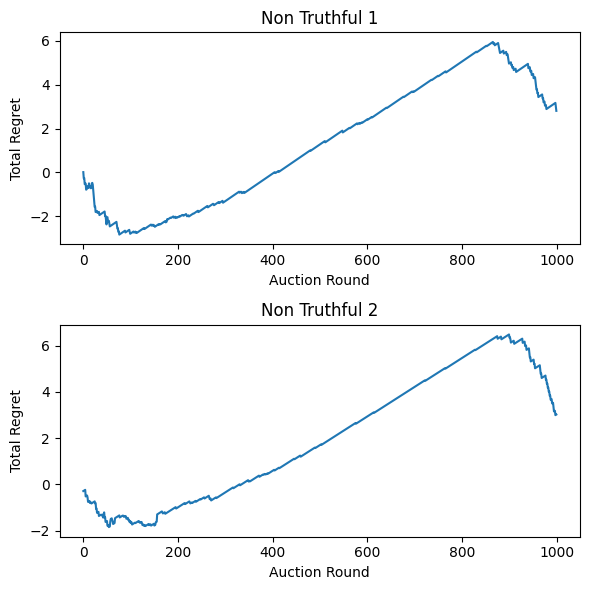

In [59]:
num_rows = total_non_truthful

fig1, ax1 = plt.subplots(num_rows, 1, figsize=(6, 3*num_rows))

if total_non_truthful == 1:
    ax1 = [ax1]

for i in range(total_non_truthful):
    row = i
    ax1[row].plot(np.arange(T), avg_regret_nt[i])
    ax1[row].fill_between(np.arange(T), avg_regret_nt[i] - std_regret_nt[i], avg_regret_nt[i] + std_regret_nt[i], alpha=0.3)
    ax1[row].set_title(f'Non Truthful {i + 1}')
    ax1[row].set_xlabel('Auction Round')
    ax1[row].set_ylabel('Total Regret')

plt.tight_layout()
plt.show()